In [1]:
# General imports 
import os 
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

In [2]:
# set data path
import sys
import platform
from os.path import join as pjoin

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


In [3]:
metadata = pd.read_csv(os.path.join(data_dir, 'bci_task_metadata', 'bci_metadata.csv'))
metadata.head()

,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
0,Brain Computer Interface,BCI single neuron stim,03f1b82e-4494-46bc-a959-50c4b14d13da,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
1,Brain Computer Interface,BCI single neuron stim,b28d6321-1b1b-4110-87fb-0e19325c1dfe,single-plane-ophys_767715_2025-02-17_17-41-50_...,767715,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-09-15,Female,Planar optical physiology,2025-02-17,155,17:41:50.758000,Primary Motor Cortex,FOV_03,8.0
2,Brain Computer Interface,BCI single neuron stim,580448b2-4b93-4477-b6ac-6e2972792fe0,single-plane-ophys_772414_2025-01-27_15-57-05_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-01-27,104,14:23:26.693000,Primary Motor Cortex,FOV_01,5.0
3,Brain Computer Interface,BCI single neuron stim,c1be8449-7bef-4967-88f5-6a6ffc29e5a3,single-plane-ophys_772414_2025-02-06_16-47-44_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-02-06,114,16:47:44.152999,Primary Motor Cortex,FOV_02,13.0
4,Brain Computer Interface,BCI single neuron stim,15b395c0-1caf-4be4-a212-a13b9a4d1dfc,single-plane-ophys_772414_2025-02-10_11-15-26_...,772414,Camk2a-tTA/wt;tetO-GCaMP6s/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-10-15,Female,Planar optical physiology,2025-02-10,118,11:15:26.609999,Primary Motor Cortex,FOV_03,14.0


In [4]:
# Pick the first mouse
subject_ids = np.sort(metadata['subject_id'].unique())
subject_id = subject_ids[0]
print('Selected subject_id is', subject_id)

# Look at its metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
this_mouse_metadata

Selected subject_id is 731015


,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
26,Brain Computer Interface,BCI single neuron stim,b8827d25-495f-46a8-9f33-ffb24da527a5,single-plane-ophys_731015_2025-01-10_18-06-31_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-10,302,16:46:51.981999,Primary Motor Cortex,FOV_04; FOV_04,18.0
27,Brain Computer Interface,BCI single neuron stim,85ff1fdd-3415-46a7-af9a-c77385a68463,single-plane-ophys_731015_2025-01-13_20-09-20_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-13,305,18:53:03.001999,Primary Motor Cortex,FOV_04,19.0
28,Brain Computer Interface,BCI single neuron stim,127a3e78-729c-4df7-bf34-1b9308939587,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-24,316,18:41:22.550000,Primary Motor Cortex,FOV_04,20.0
0,Brain Computer Interface,BCI single neuron stim,03f1b82e-4494-46bc-a959-50c4b14d13da,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
29,Brain Computer Interface,BCI single neuron stim,265c6a41-2783-4edd-b707-e4feaa77aad2,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
6,Brain Computer Interface,BCI single neuron stim,0162d41c-613c-4215-b0aa-9690f85a9fda,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-28,320,17:40:57.996000,Primary Motor Cortex,FOV_04,22.0
5,Brain Computer Interface,BCI single neuron stim,b9a4c361-66b0-4cd5-9392-75d116ef3385,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,2024-03-14,Female,Planar optical physiology,2025-01-31,323,20:37:19.623000,Primary Motor Cortex,FOV_04,23.0


In [5]:
# Let's pick the last session for this mouse
session_name = this_mouse_metadata.name.values[0]
print('Selected session is', session_name)

Selected session is single-plane-ophys_731015_2025-01-10_18-06-31_processed_2025-08-03_20-39-09


In [6]:
bci_data_dir = os.path.join(data_dir, 'brain-computer-interface')
print(bci_data_dir)

/data/brain-computer-interface


In [7]:
# Get the data folder for this session
session_dir = os.path.join(bci_data_dir, session_name)
print(session_dir)

/data/brain-computer-interface/single-plane-ophys_731015_2025-01-10_18-06-31_processed_2025-08-03_20-39-09


In [8]:
# Now find the NWB file and set the path to load it
nwb_file = [file for file in os.listdir(session_dir) if 'nwb' in file][0]
nwb_path = os.path.join(session_dir, nwb_file)
print(nwb_path)

/data/brain-computer-interface/single-plane-ophys_731015_2025-01-10_18-06-31_processed_2025-08-03_20-39-09/single-plane-ophys_731015_2025-01-10_18-06-31_behavior_nwb


In [9]:
io = NWBZarrIO(nwb_path, mode = 'r') 
nwbfile_zarr = io.read()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [10]:
with NWBZarrIO(str(nwb_path), 'r') as io:
    nwbfile = io.read()
    print('Loaded NWB file from:', nwb_path)

Loaded NWB file from: /data/brain-computer-interface/single-plane-ophys_731015_2025-01-10_18-06-31_processed_2025-08-03_20-39-09/single-plane-ophys_731015_2025-01-10_18-06-31_behavior_nwb


In [11]:
nwb2widget(nwbfile) 

In [12]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,spont,0,2399,0.000000,41.175077
1,photostim,2400,43793,41.192241,751.638250
2,spont_01,43794,49519,751.655413,849.916071
3,BCI,49520,89755,849.933234,1540.503987
4,photostim_post,89756,220343,1540.521150,3781.842460


In [13]:
# Get the dFF traces from the NWB file
cell_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
# Look at the shape - the larger dimension are the 2P frames
print(cell_traces.shape)

(220344, 1214)


In [14]:
# These are the available trials tables
nwbfile.stimulus.keys()

dict_keys(['PhotostimTrials', 'Trials'])

In [15]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()

,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,41.192241,42.307864,2400,2465,before_exp_slm_00001.tif,photostim,336.5,189.5,4,0.082,scanimage.mroi.stimulusfunctions.logspiral,27,631
1,42.325027,43.492141,2466,2534,before_exp_slm_00002.tif,photostim,53.5,60.5,4,0.082,scanimage.mroi.stimulusfunctions.logspiral,50,66
2,43.509304,44.624927,2535,2600,before_exp_slm_00003.tif,photostim,236.5,28.5,4,0.082,scanimage.mroi.stimulusfunctions.logspiral,6,99
3,44.642091,45.757714,2601,2666,before_exp_slm_00004.tif,photostim,370.5,24.5,4,0.082,scanimage.mroi.stimulusfunctions.logspiral,32,113
4,45.774878,46.890501,2667,2732,before_exp_slm_00005.tif,photostim,454.5,58.5,4,0.082,scanimage.mroi.stimulusfunctions.logspiral,31,1028


In [16]:
# Stimuli in photostim trials table
photostim['stimulus_name'].unique()

array(['photostim', 'photostim_post'], dtype=object)

In [17]:
# Load the BCI trials table
trials = nwbfile.stimulus["Trials"].to_dataframe()
trials.head()

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,849.933234,864.247538,0.2359,True,"[5.2544, 5.4253, 5.5753, 5.682, 5.793, 5.93950...",5.2544,5.1198,"[3.6918, 4.5068, 4.7348, 4.8018, 4.8368, 4.868...",neuron46_00001.tif,49520,50354,56.5,112.5,38
1,864.264701,878.046939,0.2359,True,"[6.526000000000001, 6.6604, 6.7766, 6.9938, 7....",6.5260,6.4260,"[0.5134000000000001, 0.6654, 1.1373, 1.4703000...",neuron46_00002.tif,50355,51158,56.5,112.5,38
2,878.064102,884.672024,0.2359,True,"[1.0756, 1.1934, 1.3018, 1.4094, 1.5212, 1.641...",1.0756,0.8314,"[0.2868, 0.3497, 0.4128, 0.4757, 0.5298, 0.572...",neuron46_00003.tif,51159,51544,56.5,112.5,38
3,884.689187,889.786727,0.2359,True,"[1.7614, 1.9537, 2.0812, 2.3348, 2.4525, 2.563...",1.9537,1.8503,"[0.7273000000000001, 0.8013, 0.862300000000000...",neuron46_00004.tif,51545,51842,56.5,112.5,38
4,889.803891,894.935757,0.2359,True,"[1.8142, 1.9819, 2.142, 2.4023000000000003, 2....",1.9819,1.9437,"[0.2868, 0.3557, 0.4288, 0.4937, 0.7277, 0.817...",neuron46_00005.tif,51843,52142,56.5,112.5,38


In [18]:
# Load the epochs table from the NWB file
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,spont,0,2399,0.000000,41.175077
1,photostim,2400,43793,41.192241,751.638250
2,spont_01,43794,49519,751.655413,849.916071
3,BCI,49520,89755,849.933234,1540.503987
4,photostim_post,89756,220343,1540.521150,3781.842460


In [19]:
epoch_table['duration'] = epoch_table.stop_time-epoch_table.start_time
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time,duration
id,,,,,,
0,spont,0,2399,0.000000,41.175077,41.175077
1,photostim,2400,43793,41.192241,751.638250,710.446009
2,spont_01,43794,49519,751.655413,849.916071,98.260658
3,BCI,49520,89755,849.933234,1540.503987,690.570753
4,photostim_post,89756,220343,1540.521150,3781.842460,2241.321310


In [20]:
# Get just the photostim epoch
photostim_epochs = epoch_table[epoch_table.stimulus_name.str.contains('photostim')]
photostim_epochs

,stimulus_name,start_frame,stop_frame,start_time,stop_time,duration
id,,,,,,
1,photostim,2400,43793,41.192241,751.63825,710.446009
4,photostim_post,89756,220343,1540.521150,3781.84246,2241.321310


In [21]:
# Now get the start and stop times for the photostim epochs before and after the BCI task

photostim_pre_start = photostim_epochs.loc[1].start_frame
photostim_pre_stop = photostim_epochs.loc[1].stop_frame

photostim_post_start = photostim_epochs.loc[4].start_frame
photostim_post_stop = photostim_epochs.loc[4].stop_frame

In [22]:
# Now you have the start and end frames for each epoch and can compute the duration of each
print('photostim pre 2P frames', photostim_pre_stop-photostim_pre_start)
print('photostim post 2P frames', photostim_post_stop-photostim_post_start)

photostim pre 2P frames 41393
photostim post 2P frames 130587


In [76]:
print(list(nwbfile.processing.keys()))

['processed']


In [24]:
# Get the dFF traces from the NWB file
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
# Look at the shape - the larger dimension are the 2P frames
print(dff_traces.shape)

(220344, 1214)


In [25]:
# Index into the dff traces array to limit to the relevant time points
dff_pre = dff_traces[photostim_pre_start:photostim_pre_stop, :]
# Now transpose so rows are ROI IDs
dff_pre = dff_pre.T
print(dff_pre.shape)

(1214, 41393)


In [26]:
dff_post = dff_traces[photostim_post_start:photostim_post_stop, :]
# Now transpose so rows are ROI IDs
dff_post = dff_post.T
print(dff_post.shape)

(1214, 130587)


In [27]:
#plt.pcolormesh(dff_pre, vmin=0, vmax=5, cmap='magma')
#plt.colorbar(label='dFF')
#plt.xlabel('2P frames')
#plt.ylabel('ROI ID')
#plt.title('Spontaneous pre')

In [28]:
#plt.pcolormesh(dff_post, vmin=0, vmax=5, cmap='magma')
#plt.colorbar(label='dFF')
#plt.xlabel('2P frames')
#plt.ylabel('ROI ID')
#plt.title('Spontaneous post')

In [29]:
# Get the roi_table from the NWB file
roi_table = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
roi_table.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,1,0.886588,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000000,0,8.818507e-05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,0.999333,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.220683,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0.000644,0,5.960464e-08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


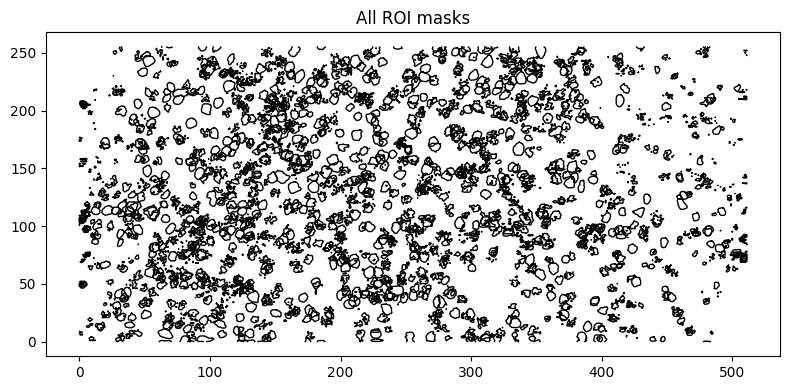

In [30]:
# Figure parameters for vertically stacked plots 
fig, ax = plt.subplots(figsize=(8, 4))

# Plot ROI contours 
for i, mask in enumerate(roi_table.image_mask):
    mask_array = np.array(mask)
    # Find contours at a level that works well for binary masks
    contours = measure.find_contours(mask_array, level=0.5)
    
    for contour in contours:
        color = 'k'
        linewidth = 1.0
        # Plot contour (note: contour coordinates are in (row, col) format)
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)
        
# Label
ax.set_title('All ROI masks')

plt.tight_layout()
plt.show()

In [31]:
# Remove ROIs with traces that are NaNs (note - this takes a few seconds)
valid_trace_ids = [i for i in range(cell_traces.shape[1]) if np.isnan(cell_traces[0, i])==False]
# Limit ROI table to non-NaN traces
roi_table = roi_table.loc[valid_trace_ids]

In [32]:
# Find the likely somatic ROIs
soma_probability = 0.005 # Emperically determined threshold - just trust us
# Limit to valid somatic ROIs
valid_rois = roi_table[roi_table.soma_probability>soma_probability]
print('there are', len(valid_rois), 'ROIs with soma_probability >',soma_probability)

there are 225 ROIs with soma_probability > 0.005


In [33]:
# First load our average image
average_image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:] 
average_image.shape

(256, 512)

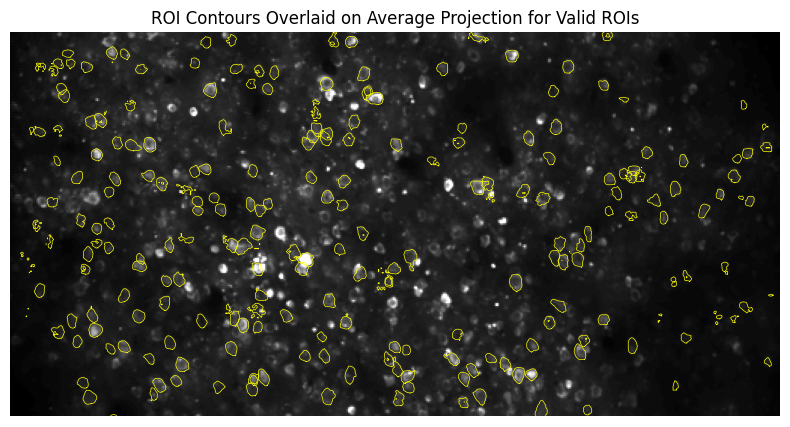

In [34]:
# Plot ROI contours overlayed on average image 
fig, ax = plt.subplots(figsize=(8, 6))

# First plot average image
ax.imshow(average_image, cmap='gray', origin='upper', aspect='equal', vmax=0.25)
ax.set_title('ROI Contours Overlaid on Average Projection for Valid ROIs')
ax.axis('off')

# Overlay ROI contours
for i, mask in enumerate(valid_rois.image_mask):
    mask_array = np.array(mask)
    # Find contours at a level that works well for binary masks
    contours = measure.find_contours(mask_array, level=0.5)
    
    for contour in contours:
        color = 'yellow'
        linewidth = 0.5
        
        # Plot contour (note: contour coordinates are in (row, col) format)
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)
        
# Set the axis limits to match the image dimensions
ax.set_xlim(0, average_image.shape[1])
ax.set_ylim(average_image.shape[0], 0)  # Flip y-axis to match image coordinates

plt.tight_layout()
plt.show()

In [35]:
# Check the shape of our dff traces array - the longer axis is 2P frames, the shorter one is ROIs
dff_pre.shape

(1214, 41393)

In [36]:
# Limit dff traces for spontaneous activity period before the task to valid ROIs
dff_pre = dff_pre[valid_rois.index.values, :]
print(dff_pre.shape)

(225, 41393)


In [37]:
# Limit dff traces for spontaneous activity period before the task to valid ROIs
dff_post = dff_post[valid_rois.index.values, :]
print(dff_post.shape)

(225, 130587)


Text(0.5, 1.0, 'Photostimulation pre')

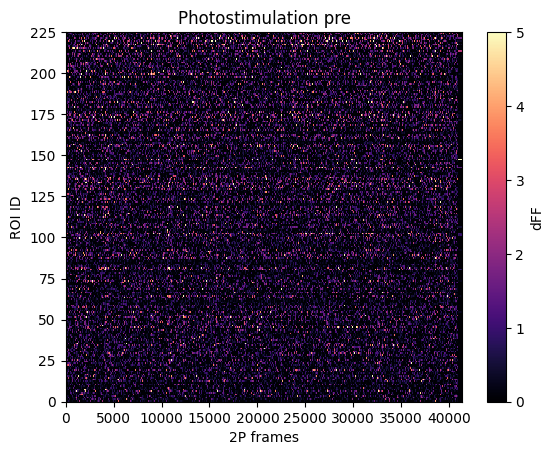

In [38]:
plt.pcolormesh(dff_pre, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Photostimulation pre')

Text(0.5, 1.0, 'Photostimulation post')

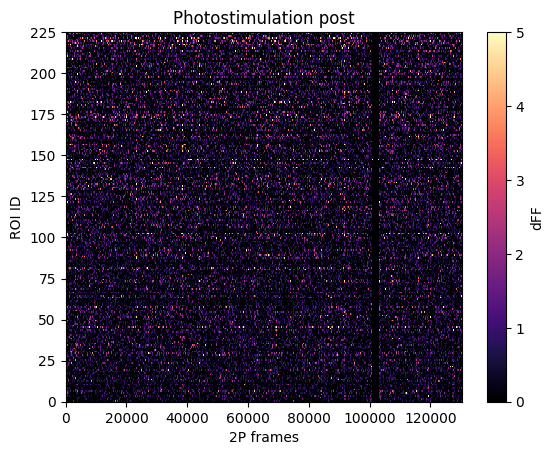

In [39]:
plt.pcolormesh(dff_post, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Photostimulation post')

In [40]:
correlations_pre = np.corrcoef(dff_pre)
correlations_post = np.corrcoef(dff_post)

correlations_pre.shape

(225, 225)

(np.float64(0.0), np.float64(225.0), np.float64(0.0), np.float64(225.0))

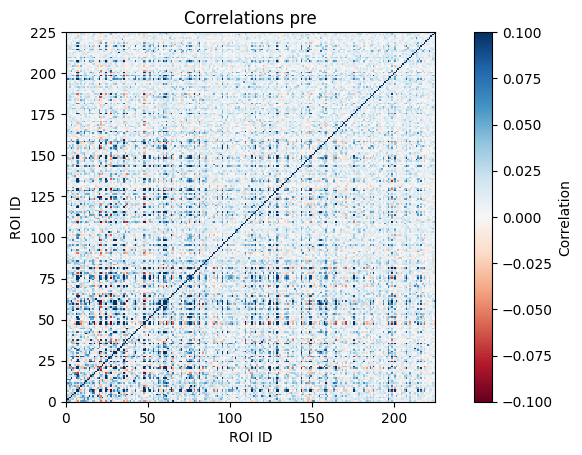

In [41]:
plt.pcolormesh(correlations_pre, cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations pre')
plt.axis('square')

(np.float64(0.0), np.float64(225.0), np.float64(0.0), np.float64(225.0))

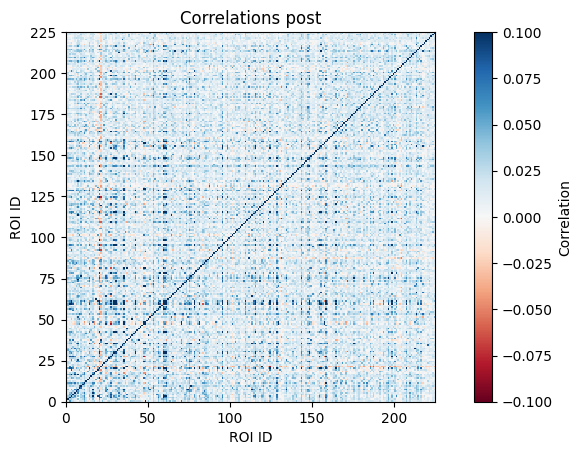

In [42]:
plt.pcolormesh(correlations_post, cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations post')
plt.axis('square')

In [43]:
correlations_pre = np.triu(correlations_pre, k=1)
correlations_post = np.triu(correlations_post, k=1)

(np.float64(0.0), np.float64(225.0), np.float64(0.0), np.float64(225.0))

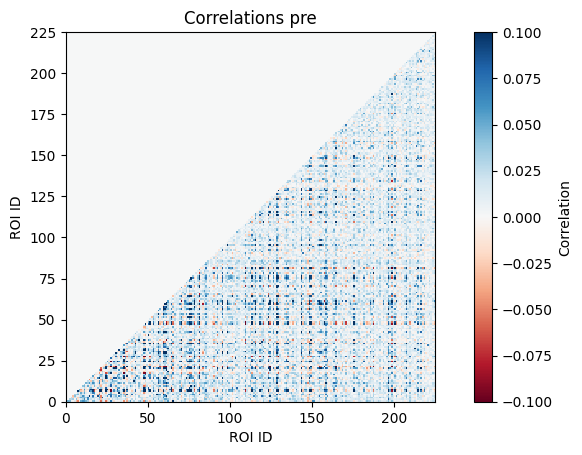

In [44]:
plt.pcolormesh(correlations_pre, cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations pre')
plt.axis('square')

(np.float64(0.0), np.float64(225.0), np.float64(0.0), np.float64(225.0))

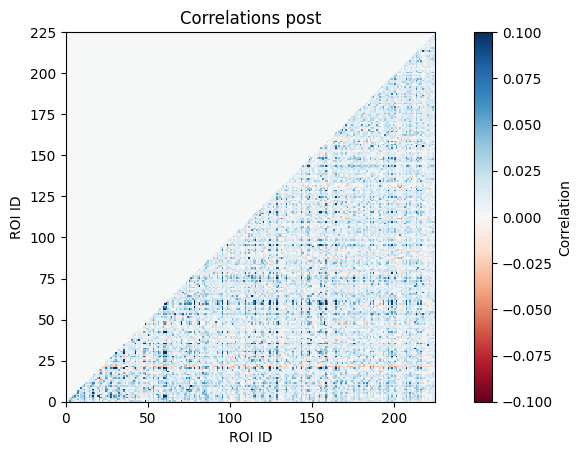

In [45]:
plt.pcolormesh(correlations_post, cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations post')
plt.axis('square')

In [46]:
t, p_val = stats.ttest_ind(correlations_pre.flatten(), correlations_post.flatten())
print(p_val)

1.1874446304991868e-16


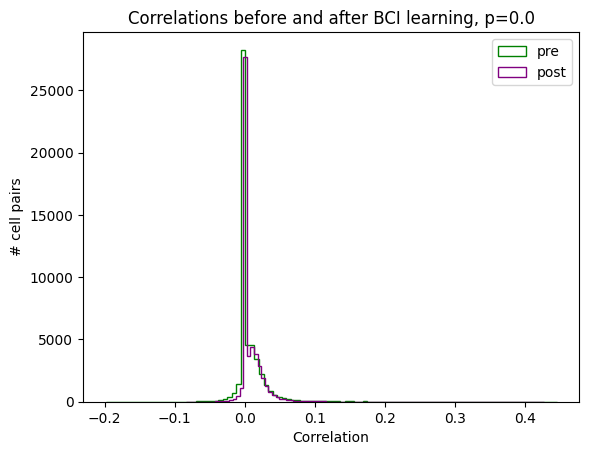

In [47]:
# Plot both distributions
plt.hist(correlations_pre.flatten(), bins=100, color='green', label='pre', histtype='step')
plt.hist(correlations_post.flatten(), bins=100, color='purple', label='post', histtype='step')
plt.title('Correlations before and after BCI learning, p='+str(np.round(p_val, 5)))
plt.xlabel('Correlation')
plt.ylabel('# cell pairs')
#plt.xlim(-0.1, 0.1)
plt.legend()

In [48]:
def get_roi_centroids(roi_table):
    '''
    Iterate through the image masks in the ROI table, 
    get the indices corresponding to each ROI, 
    then take the average to get the x and y locations of the cell centroid. 
    
    Returns an array with dimensions (n_cells, xy_position)
    '''
    centroids = []
    for mask in roi_table['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

In [49]:
# Calculate centroids for each ROI 
centroids = get_roi_centroids(valid_rois)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

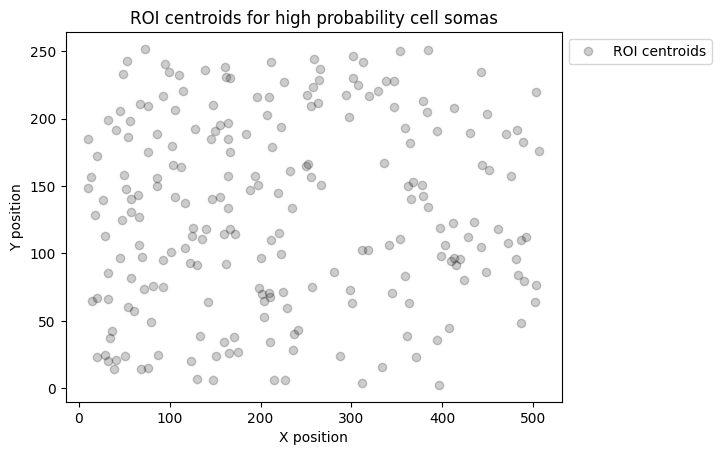

In [50]:
# Now plot them
plt.plot(centroidX, centroidY, 'ko', alpha = 0.2, label = 'ROI centroids')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.title('ROI centroids for high probability cell somas')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [51]:
import math

In [52]:
centroid_cell_1 = centroids[0, :]
centroid_cell_2 = centroids[1, :]

math.dist(centroid_cell_1, centroid_cell_2)

224.18485746075098

In [53]:
pairs_data = []
for roi_id_1 in range(len(valid_rois.index.values)): 
    for roi_id_2 in range(len(valid_rois.index.values)): 
        centroid_cell_1 = centroids[roi_id_1, :]
        centroid_cell_2 = centroids[roi_id_2, :]
        distance = math.dist(centroid_cell_1, centroid_cell_2)
        r_value_pre = correlations_pre[roi_id_1, roi_id_2]
        r_value_post = correlations_post[roi_id_1, roi_id_2]
        r_value_diff = r_value_post-r_value_pre
        pairs_data.append([roi_id_1, roi_id_2, r_value_pre, r_value_post, r_value_diff, distance])

In [54]:
len(pairs_data)

50625

In [55]:
pairs = pd.DataFrame(pairs_data, columns=['roi_id_1', 'roi_id_2', 'r_value_pre', 'r_value_post', 'r_value_diff', 'distance'])
pairs.head()

,roi_id_1,roi_id_2,r_value_pre,r_value_post,r_value_diff,distance
0,0,0,0.000000,0.000000,0.000000,0.000000
1,0,1,0.047891,0.012939,-0.034952,224.184857
2,0,2,0.045444,0.058351,0.012907,278.890512
3,0,3,0.003424,0.026574,0.023150,43.075089
4,0,4,-0.002333,0.021406,0.023739,289.199055


In [56]:
pairs["r_value_diff"].max()

np.float64(0.163216419050689)

Text(0.5, 1.0, 'Activity correlation as a function of distance for cell pairs')

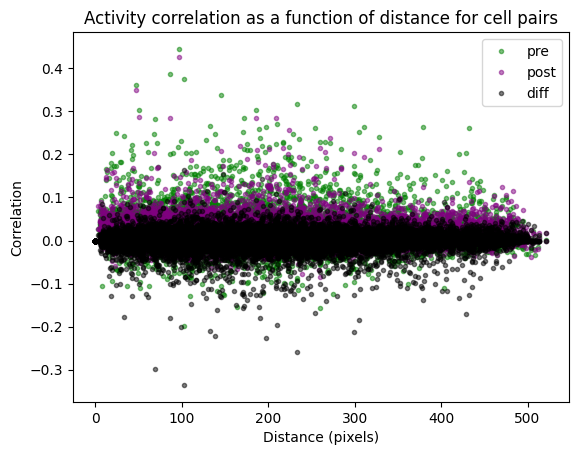

In [59]:
plt.plot(pairs.distance.values, pairs.r_value_pre.values, '.', color='green', label='pre', alpha=0.5)
plt.plot(pairs.distance.values, pairs.r_value_post.values, '.', color='purple', label='post', alpha=0.5)
plt.plot(pairs.distance.values, pairs.r_value_diff, '.', color='black', label='diff', alpha=0.5)
plt.legend()
plt.ylabel('Correlation')
plt.xlabel('Distance (pixels)')
plt.title('Activity correlation as a function of distance for cell pairs')

In [60]:
# Select the top 2000 gene pairs with the largest absolute differences in correlation
# between conditions, while preserving the original signed values in r_value_diff.
# This sorts by absolute magnitude but keeps both positive and negative differences.
top_n = 2000
top_pairs = pairs.reindex(pairs['r_value_diff'].abs().sort_values(ascending=False).index).head(top_n)


In [61]:
top_pairs

,roi_id_1,roi_id_2,r_value_pre,r_value_post,r_value_diff,distance
1656,7,81,0.375023,0.039787,-0.335236,102.110320
1596,7,21,0.280976,-0.018002,-0.298978,69.447840
1357,6,7,0.317718,0.059239,-0.258479,232.906139
1622,7,47,0.264239,0.038413,-0.225826,197.702137
1431,6,81,0.247011,0.024801,-0.222210,138.275058
...,...,...,...,...,...,...
3043,13,118,-0.001008,0.026615,0.027623,396.167718
12084,53,159,0.044353,0.016745,-0.027608,228.239290
14699,65,74,-0.007570,0.020024,0.027594,65.512794
14930,66,80,0.026554,0.054146,0.027592,292.619900


Text(0.5, 1.0, 'Activity correlation as a function of distance for top 500 cell pairs')

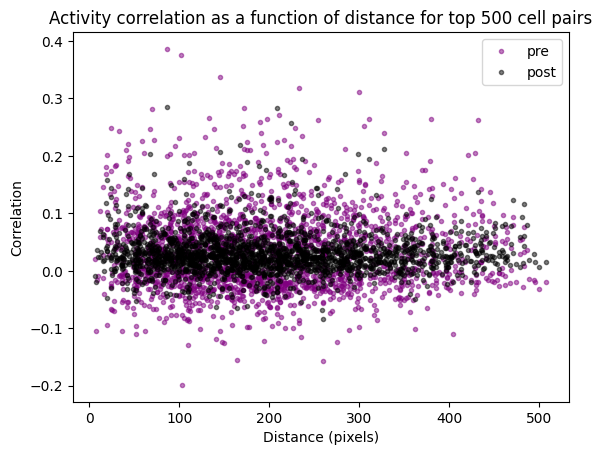

In [62]:
#plt.plot(top_pairs.distance.values, filtered_pairs.r_value_diff, '.', color='green', label='pre', alpha=0.5)
plt.plot(top_pairs.distance.values, top_pairs.r_value_pre.values, '.', color='purple', label='pre', alpha=0.5)
#plt.plot(top_pairs.distance.values, top_pairs.r_value_post_values, '.', color='black', label='diff', alpha=0.5)
plt.plot(top_pairs.distance.values, top_pairs.r_value_post.values, '.', color='black', label='post', alpha=0.5)

plt.legend()
plt.ylabel('Correlation')
plt.xlabel('Distance (pixels)')
plt.title('Activity correlation as a function of distance for top 500 cell pairs')

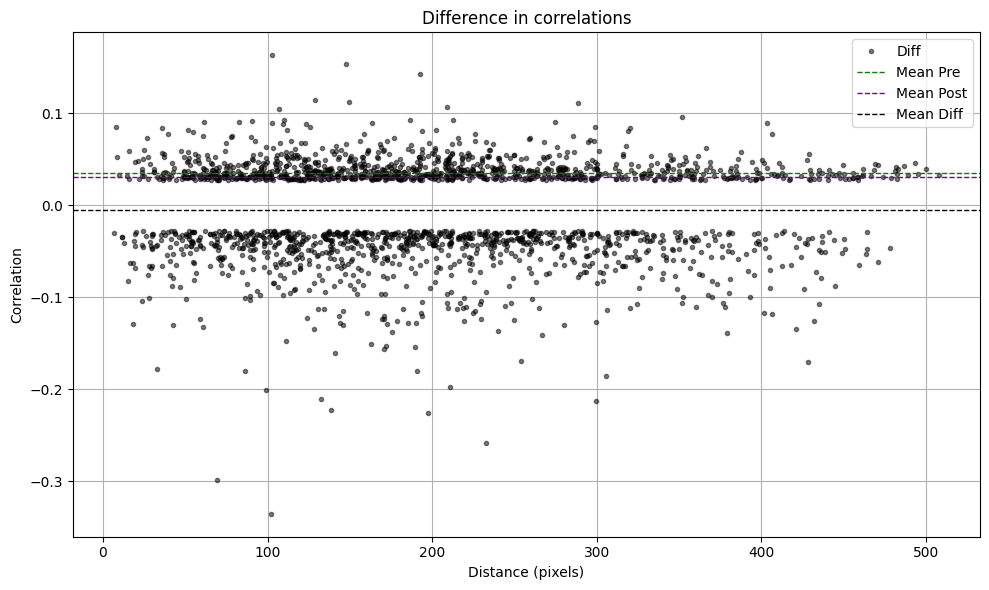

In [63]:
# Compute means
mean_pre = top_pairs.r_value_pre.mean()
mean_post = top_pairs.r_value_post.mean()
mean_diff = top_pairs.r_value_diff.mean()

plt.figure(figsize=(10, 6))

# Scatter plots
#plt.plot(top_pairs.distance.values, top_pairs.r_value_pre.values, '.', color='green', label='Pre', alpha=0.5)
#plt.plot(top_pairs.distance.values, top_pairs.r_value_post.values, '.', color='purple', label='Post', alpha=0.5)
plt.plot(top_pairs.distance.values, top_pairs.r_value_diff.values, '.', color='black', label='Diff', alpha=0.5)

# Horizontal mean lines
plt.axhline(mean_pre, color='green', linestyle='--', linewidth=1, label='Mean Pre')
plt.axhline(mean_post, color='purple', linestyle='--', linewidth=1, label='Mean Post')
plt.axhline(mean_diff, color='black', linestyle='--', linewidth=1, label='Mean Diff')

# Labels
plt.legend()
plt.ylabel('Correlation')
plt.xlabel('Distance (pixels)')
plt.title('Difference in correlations')
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
top_data = top_pairs['r_value_diff'].values.reshape(-1, 1)

array([[-0.33523615],
       [-0.29897828],
       [-0.25847879],
       ...,
       [ 0.02759384],
       [ 0.0275922 ],
       [ 0.02756341]], shape=(2000, 1))

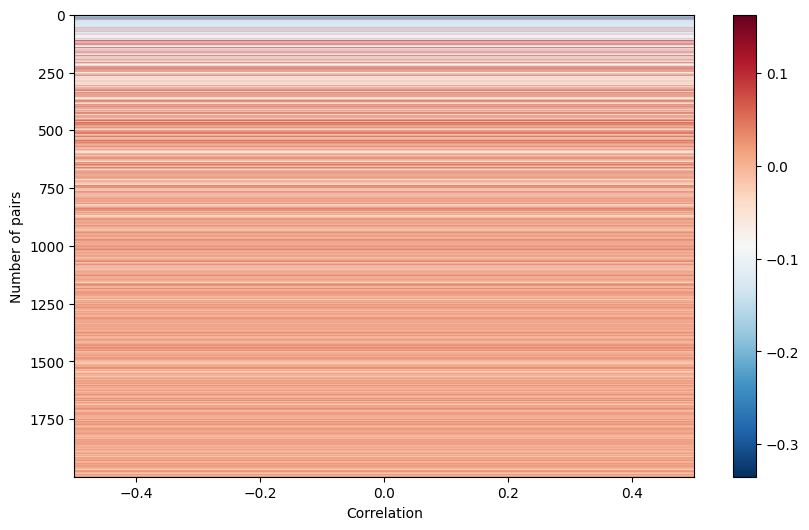

In [73]:
plt.figure(figsize=(10, 6))
plt.imshow(top_data, cmap='RdBu_r', aspect='auto')
plt.colorbar()
#plt.title('Your Title Here')
plt.xlabel('Correlation')
plt.ylabel('Number of pairs')
plt.show()